In [148]:
!pip install torchsummary

In [218]:
! pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

Looking in indexes: https://pypi.org/simple, https://developer.download.nvidia.com/compute/redist
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.5/485.5 MB 1.4 MB/s eta 0:00:0000:0100:02


In [149]:
import time
import copy
import pickle
import json
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import dump

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset, TensorDataset
from torch.utils.data.dataset import random_split
from torchsummary import summary
import torchvision.models as models
import torchvision.transforms as transforms

from keras.utils.np_utils import to_categorical  

In [150]:
# Enable gpu support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [151]:
# !gdown 1sc2qFcOeJp2hYAj50i8Xj9VwW6qfePAl

In [152]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Data extraction and preprocessing

In [153]:
data = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv')
# data = pd.read_csv('data.csv')


In [154]:
display(data.head())
data.shape

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


(28709, 2)

In [155]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 672.9+ KB


In [156]:
X = np.array([
              [i for i in map(int, row)] for row 
              in map(str.split, data['pixels'].values)
      ]).reshape((-1, 48, 48))

In [157]:
X.dtype

dtype('int64')

In [158]:
X.shape

(28709, 48, 48)

In [159]:
y = data['emotion']
display(y.value_counts())
y = y.values

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

In [160]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
)

# Dataset

In [262]:
class EmotionsDataset(Dataset):
  def __init__(self, X, y, standardization_mode, transforms=None, online_transforms=None,
               augmentation_epochs=7, to_rgb=True):
    super().__init__()
    
    self.stransforms = transforms
    self.online_transforms = online_transforms
    self.augmentation_epochs = augmentation_epochs

    self.standardization_mode = standardization_mode
    self.standardization_filename = 'mean_std.json'


    if self.stransforms:
      self.X, self.y = self._augment(X, y)
    else:
      self.X = torch.from_numpy(X).float().to(device)
      self.y = y

    self.y_categorical = torch.from_numpy(
        to_categorical(self.y, num_classes=7)
    ).float().to(device)

    self.X = self._standardize(self.X)
    if len(self.X.shape) != 4:
      self.X.unsqueeze_(1)

    if to_rgb:
      self.X = self.X.repeat(1, 3, 1, 1)
  
  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, index):
    if self.online_transforms:
        self.online_transforms(self.X[index]), self.y_categorical[index]
        
    return self.X[index], self.y_categorical[index]
  
  def _standardize(self, X):
    if self.standardization_mode == 'fit_transform':
        mean, std = X.mean(), X.std()

        with open(self.standardization_filename, 'w', encoding ='utf8') as file:
            json.dump({
                'mean': float(mean),
                'std': float(std)
            }, file)

    elif self.standardization_mode == 'transform':
        with open(self.standardization_filename, 'r', encoding ='utf8') as file:
            data = json.load(file)
      
        mean, std = data['mean'], data['std']
    
    elif self.standardization_mode == 'None':
        return X
      
    else:
        raise TypeError(
          'Unkown option "standardization_mode"\n'
          'Choose from: fit_transform, transform\n'
      )
    
    return transforms.Normalize(mean, std)(X)
  
  def _augment(self, X, y):
    # Sampler
    counts = np.unique(y, return_counts=True)[1]
    class_weights = np.power(counts, -1, dtype=float)

    sample_weights = [class_weights[label] for i, label in enumerate(y)]

    sampler = WeightedRandomSampler(sample_weights, 
                                    num_samples=len(sample_weights),
                                    replacement=True)

    # Dataset
    dataset = TensorDataset(torch.from_numpy(X).unsqueeze(1),
                            torch.from_numpy(y_train))

    # DataLoaders
    dataset_loader = DataLoader(dataset, batch_size=1, sampler=sampler)

    # Augmentation
    X_train_augmented, y_train_augmented = [], []
    for _ in range(self.augmentation_epochs):
      for batch in dataset_loader:
        X_train_augmented.append(transform(batch[0]).squeeze(0))
        y_train_augmented.append(batch[1])

    X_train_augmented = torch.stack(X_train_augmented).float().to(device)
    y_train_augmented = torch.stack(y_train_augmented).numpy()

    return X_train_augmented, y_train_augmented

# Data visualisation & augmentation

In [162]:
target_names = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral',
}

In [163]:
def plot_images(X, y, transform=None, classes=7, columns=10):
  _X = np.zeros((classes * columns, 48, 48))
  _y = []
  
  X, y = copy.deepcopy(X), copy.deepcopy(y)

  if transform:
    X_tensor = torch.from_numpy(X).unsqueeze(1)
    X_augmented = torch.stack([transform(image_tensor) for image_tensor in X_tensor])

    X = X_augmented.squeeze(1).cpu()


  for label in range(classes):
    mask = (y == label)
    _X[columns * label : columns * label + columns] = X[mask, :][:columns]
    _y.extend([label] * columns)

  _, axes = plt.subplots(nrows=classes, ncols=columns, figsize=(15, 12))
  for ax, image, label in zip(axes.flatten(), _X, _y):
      ax.set_xticks([])
      ax.set_yticks([])
      ax.imshow(image, cmap=plt.cm.gist_gray)
      ax.set_title(target_names[label])

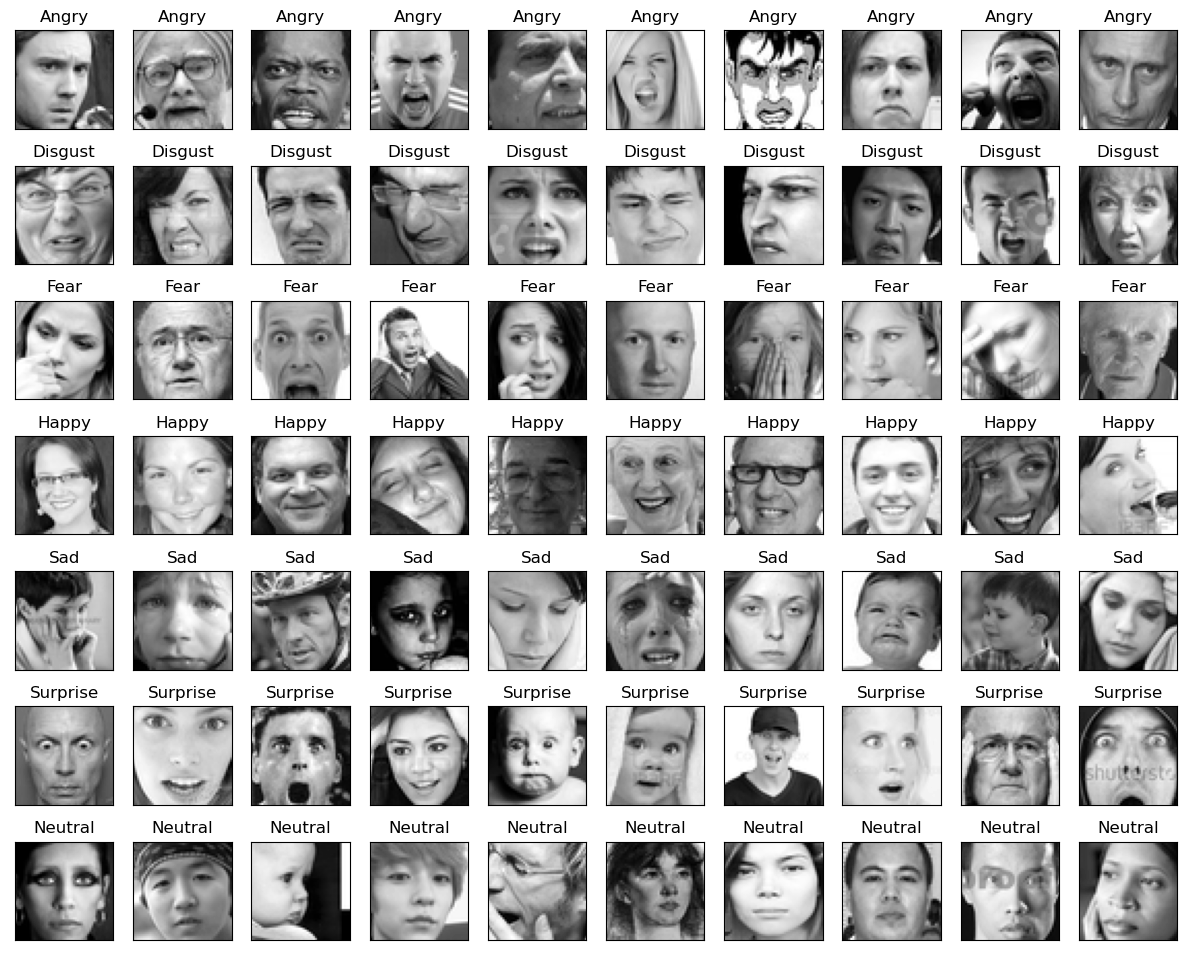

In [164]:
plot_images(X, y)

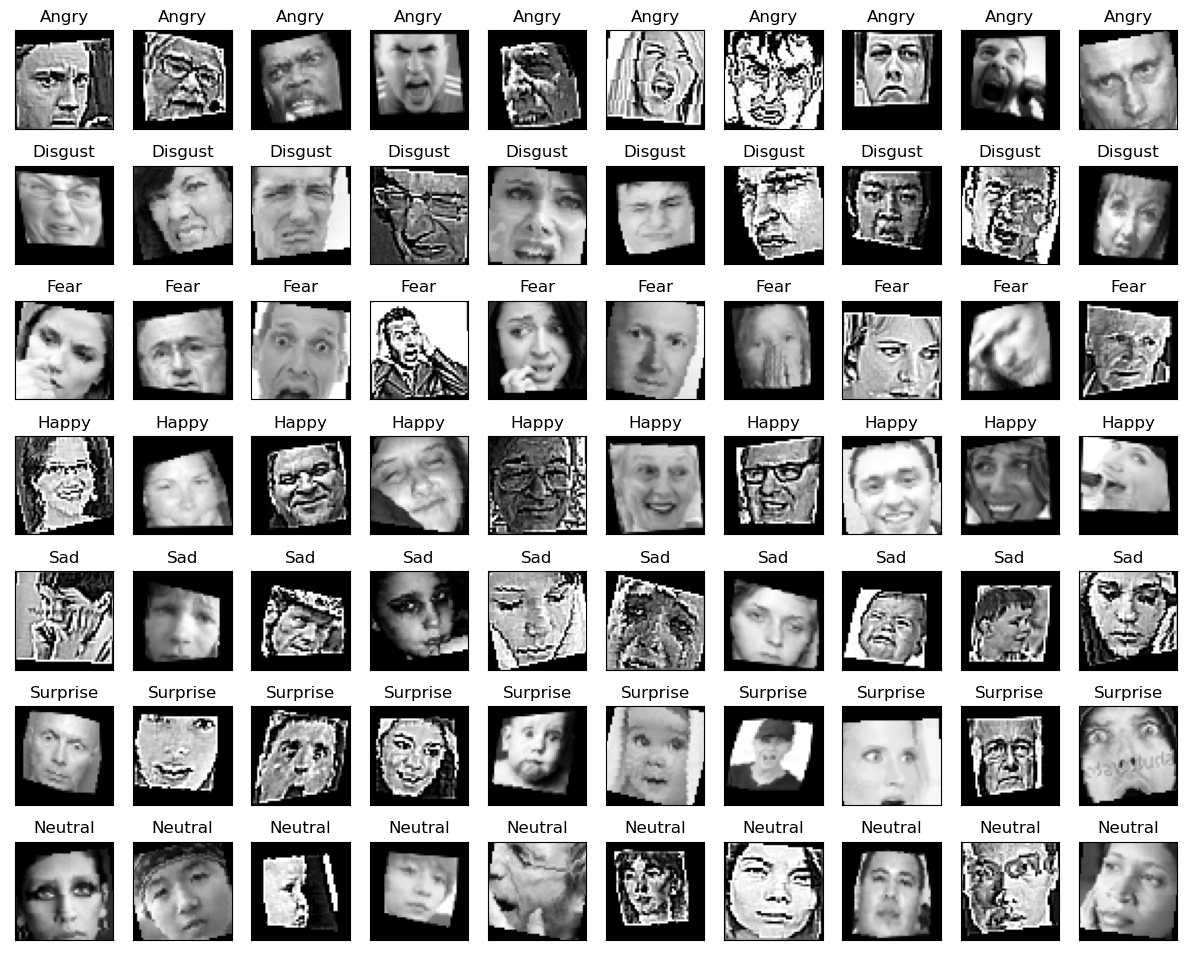

In [165]:
transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomAffine(degrees=(-15, 15), translate=(0.01, 0.15)),
      transforms.RandomPerspective(distortion_scale=0.35),
      transforms.RandomAdjustSharpness(sharpness_factor=10)
])
plot_images(X, y, transform)

# Datasets

In [166]:
# Datasets
# train_augmented = EmotionsDataset(X_train, y_train, 'fit_transform', transform)
# val_augmented = EmotionsDataset(X_val, y_val, standardization_mode='transform')
# test_augmented = EmotionsDataset(X_test, y_test, standardization_mode='transform')

In [263]:
train_not_augmented = EmotionsDataset(X_train, y_train, 'fit_transform')
val_not_augmented = EmotionsDataset(X_val, y_val, standardization_mode='transform')
test_not_augmented = EmotionsDataset(X_test, y_test, standardization_mode='transform')

In [168]:
train_augmented_online = EmotionsDataset(X_train, y_train, 'fit_transform', online_transforms=transform)
val_augmented_online = EmotionsDataset(X_val, y_val, standardization_mode='transform')
test_augmented_online = EmotionsDataset(X_test, y_test, standardization_mode='transform')

# Plots

In [169]:
def plot_confusin_matrix(y_real, y_test):
  confusion_matrix = metrics.confusion_matrix(y_real, y_test)
  sns.heatmap(confusion_matrix, center=0, cmap='PiYG', annot=True)

  plt.show()

In [170]:
def plot_loss(train_loss, test_loss, ylim=False):
  x = [i for i in range(1, len(train_loss) + 1)]

  plt.plot(x, train_loss, label='train')
  plt.plot(x, test_loss, label='test')

  if ylim:
    plt.ylim(0, 10)

  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [171]:
def plot_accuracy(train_accuracies, test_accuracies, step):
  x = [i for i in range(1, step * len(train_accuracies) + 1, step)]

  plt.plot(x, train_accuracies, label='train')
  plt.plot(x, test_accuracies, label='validation')

  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

# Models

In [147]:
# list(models.resnet50(pretrained=True).children())

In [172]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    self.backbone =  nn.Sequential(*list(resnet.children())[:-2])

    self.model = nn.Sequential(
        self.backbone,
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        nn.Flatten(),
        nn.Dropout1d(p=0.5),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.Dropout1d(p=0.3),
        nn.ReLU(),
        nn.Linear(256, 7)
    )

    # for param in self.model[1].parameters():
    #   param.requires_grad = False

  def forward(self, x):
    return self.model(x)

In [173]:
# summary(Net().float().to(device), input_size=(3, 48, 48))

# Pipeline functions

In [174]:
# Testing model
def test_model(model, test_loader, criterion=None, return_predictions=False):
    predictions = []
    labels = []
    loss_sum = 0.
    
    for images, y in test_loader: 
      with torch.no_grad(): 
        outputs = model(images)

        if criterion:
          loss_sum += criterion(outputs, y)

        predictions += torch.argmax(outputs.data, axis=1).cpu()
        labels += torch.argmax(y.data, axis=1).cpu()
    
    d = {}

    d['accuracy'] = metrics.accuracy_score(labels, predictions)

    if return_predictions:
      d['predictions'] = predictions
    
    if criterion:
      d['loss'] = (loss_sum / len(test_loader)).cpu()
    
    return d

In [175]:
# Training model
def train_model(model, optimizer, scheduler, train_loader, test_loader,
                epochs, test_step, transform):
    print('\n* Model training * ')
    
    criterion = nn.CrossEntropyLoss()

    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        print(f'* Epoch #{epoch + 1}')
        model.train()

        for batch, (images, labels) in enumerate(train_loader):
          optimizer.zero_grad()
          
          # forward
          outputs = model(transform(images))
          loss = criterion(outputs, labels)

          # backward
          loss.backward()
          # torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1)
          
          optimizer.step()
        
        # validation
        model.eval()
        if epoch % test_step == 0:
          train_dict = test_model(model, train_loader, criterion=criterion)
          train_accuracies.append(train_dict['accuracy'])
          train_losses.append(train_dict['loss'])

          test_dict = test_model(model, test_loader, criterion=criterion)
          test_accuracies.append(test_dict['accuracy'])
          test_losses.append(test_dict['loss'])

          
          print('\tTrain accuracy', train_dict['accuracy'])
          print('\tTest accuracy', test_dict['accuracy'])
          print()
          print('\tTrain loss', train_dict['loss'])
          print('\tTest loss', test_dict['loss'])
          print()
          scheduler.step(test_dict['loss'])

    return {
        'train_accuracies': train_accuracies, 
        'test_accuracies': test_accuracies, 
        'train_losses': train_losses,
        'test_losses': test_losses
        }

In [178]:
def run_pipeline(train, val, test, transform,
    batch_size=2048,
    lr=5e-4,
    epochs=1,
    test_step=1,
    weight_decay=0.01,
    max_lr=1e-3,
    show_summary=False,
    random_state=42):

    # Reproducibility
    torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)

    # DataLoaders
    train_loader = DataLoader(train,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True, num_workers=0)

    val_loader = DataLoader(val,
                            batch_size=batch_size,
                            shuffle=False)
    test_loader = DataLoader(test,
                             batch_size=batch_size,
                             shuffle=False)

    # Model
    net = Net().float().to(device)
    
    # Clip gradient norm     
    nn.utils.clip_grad_norm_(parameters=net.parameters(), max_norm=1, norm_type=2.0)
    
    # Model summary
    if show_summary:
        summary(net, (3, 48, 48))

    # Optimizer
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr,
                                  weight_decay=weight_decay)

    # LR scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, verbose=True)

    # Training
    train_results = train_model(net, optimizer, scheduler, 
                                train_loader, val_loader, epochs, test_step, transform)
    # Testing
    test_results = test_model(net, test_loader, return_predictions=True)
    print('Accuracy: ', test_results['accuracy'])

    # Plots
    plot_confusin_matrix(y_test, test_results['predictions'])
    plot_loss(train_results['train_losses'], train_results['test_losses'])
    # plot_loss(train_results['train_losses'], train_results['test_losses'], ylim=True)
    plot_accuracy(train_results['train_accuracies'], train_results['test_accuracies'],
                  test_step)
    
    # Save model
    torch.save(net.state_dict(), 'model.pth')

    return net

# Sandox

In [277]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    self.backbone =  nn.Sequential(*list(resnet.children())[:-2])

    self.model = nn.Sequential(
        self.backbone,
        
        nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        
        nn.AdaptiveAvgPool2d(output_size=(1, 1)),
        nn.Flatten(),
        nn.Dropout1d(p=0.5),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.Dropout1d(p=0.3),
        nn.ReLU(),
        nn.Linear(256, 7)
    )

    # for param in self.model[1].parameters():
    #   param.requires_grad = False

  def forward(self, x):
    return self.model(x)

In [268]:
transform = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomAffine(degrees=(-15, 15), translate=(0.01, 0.15)),
      transforms.RandomPerspective(distortion_scale=0.35),
#       transforms.RandomAdjustSharpness(sharpness_factor=10)
])


* Model training * 
* Epoch #1
	Train accuracy 0.4063377808988764
	Test accuracy 0.40334378265412746

	Train loss tensor(1.6362)
	Test loss tensor(1.6412)

* Epoch #2
	Train accuracy 0.4138869382022472
	Test accuracy 0.4110066179031696

	Train loss tensor(1.6164)
	Test loss tensor(1.6120)

* Epoch #3
	Train accuracy 0.4900807584269663
	Test accuracy 0.49808429118773945

	Train loss tensor(1.4525)
	Test loss tensor(1.4464)

* Epoch #4
	Train accuracy 0.49701544943820225
	Test accuracy 0.4845001741553466

	Train loss tensor(1.3771)
	Test loss tensor(1.3809)

* Epoch #5
	Train accuracy 0.5241836376404494
	Test accuracy 0.5158481365377917

	Train loss tensor(1.4127)
	Test loss tensor(1.4155)

* Epoch #6
	Train accuracy 0.5211113061797753
	Test accuracy 0.51619644723093

	Train loss tensor(1.4287)
	Test loss tensor(1.4340)

* Epoch #7
	Train accuracy 0.5510884831460674
	Test accuracy 0.546151166840822

	Train loss tensor(1.3599)
	Test loss tensor(1.3596)

* Epoch #8
	Train accuracy 0.54542

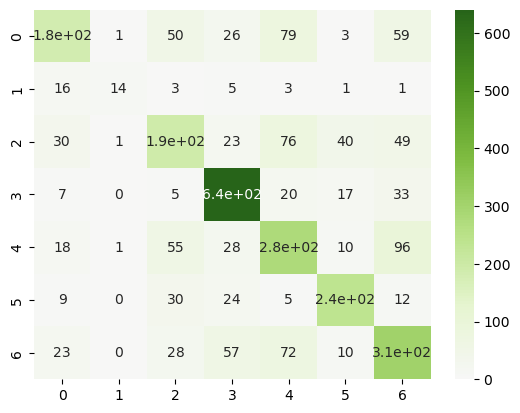

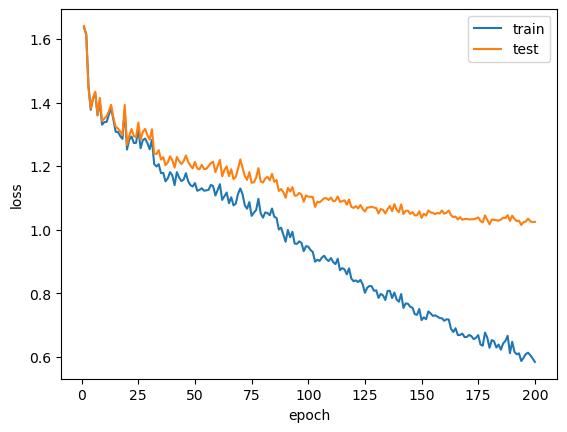

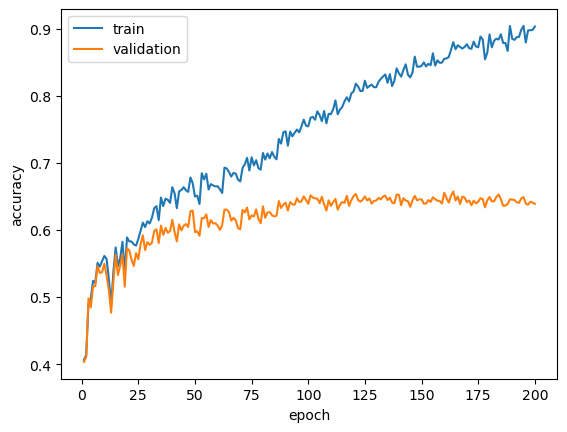

In [279]:
model = run_pipeline(train_not_augmented, val_not_augmented, test_not_augmented, transform,
             epochs=200, batch_size=256, test_step=1, lr=1e-3, weight_decay=0.01)


* Model training * 
* Epoch #1
	Train accuracy 0.39128335674157305
	Test accuracy 0.38662486938349006

	Train loss tensor(1.6167)
	Test loss tensor(1.6146)

* Epoch #2
	Train accuracy 0.47208567415730335
	Test accuracy 0.46917450365726227

	Train loss tensor(1.4710)
	Test loss tensor(1.4692)

* Epoch #3
	Train accuracy 0.520409058988764
	Test accuracy 0.5304771856495994

	Train loss tensor(1.3331)
	Test loss tensor(1.3168)

* Epoch #4
	Train accuracy 0.48709620786516855
	Test accuracy 0.4785788923719958

	Train loss tensor(1.3411)
	Test loss tensor(1.3510)

* Epoch #5
	Train accuracy 0.5440660112359551
	Test accuracy 0.5238592824799722

	Train loss tensor(1.2708)
	Test loss tensor(1.2859)

* Epoch #6
	Train accuracy 0.5334884129213483
	Test accuracy 0.5238592824799722

	Train loss tensor(1.2915)
	Test loss tensor(1.3088)

* Epoch #7
	Train accuracy 0.5613149578651685
	Test accuracy 0.5475444096133751

	Train loss tensor(1.2383)
	Test loss tensor(1.2455)

* Epoch #8
	Train accuracy 0.5

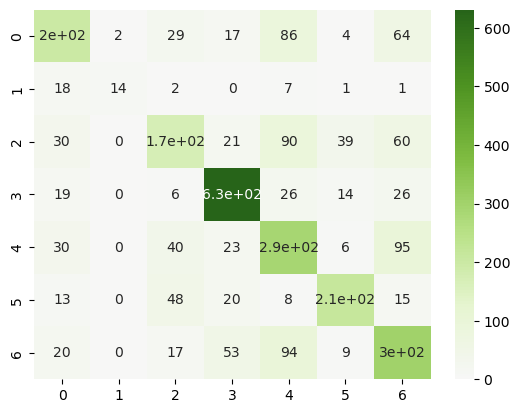

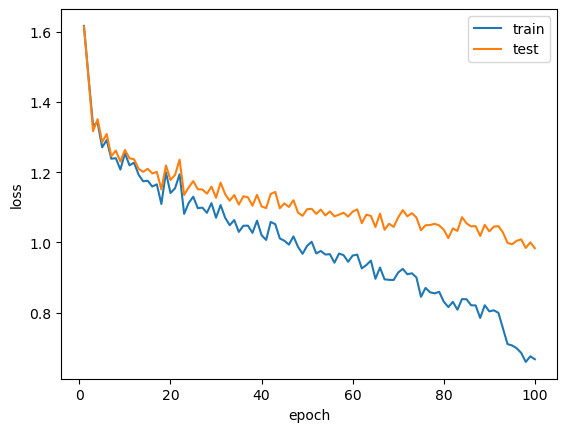

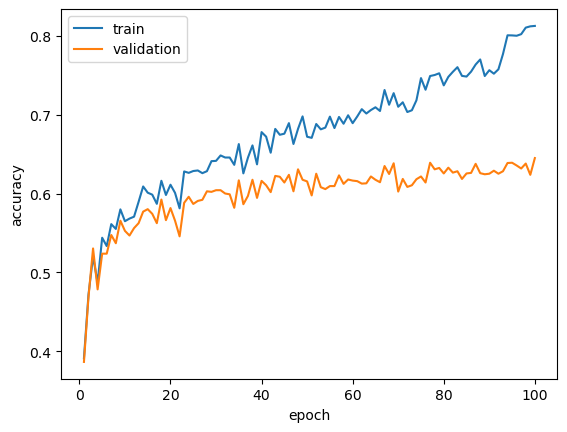

In [275]:
model = run_pipeline(train_not_augmented, val_not_augmented, test_not_augmented, transform,
             epochs=100, batch_size=256, test_step=1, lr=1e-3, weight_decay=0.01)


* Model training * 
* Epoch #1
	Train accuracy 0.41996626420454547
	Test accuracy 0.42737722048066873

	Train loss tensor(1.5263)
	Test loss tensor(1.5191)

* Epoch #2
	Train accuracy 0.43852095170454547
	Test accuracy 0.4228491814698711

	Train loss tensor(1.4316)
	Test loss tensor(1.4357)

* Epoch #3
	Train accuracy 0.4924982244318182
	Test accuracy 0.4952978056426332

	Train loss tensor(1.4415)
	Test loss tensor(1.4351)

* Epoch #4
	Train accuracy 0.4841086647727273
	Test accuracy 0.47648902821316613

	Train loss tensor(1.4097)
	Test loss tensor(1.4181)

* Epoch #5
	Train accuracy 0.5092329545454546
	Test accuracy 0.5067920585161965

	Train loss tensor(1.3582)
	Test loss tensor(1.3645)

* Epoch #6
	Train accuracy 0.5500710227272727
	Test accuracy 0.5357018460466736

	Train loss tensor(1.2760)
	Test loss tensor(1.2885)

* Epoch #7
	Train accuracy 0.5325816761363636
	Test accuracy 0.5214211076280042

	Train loss tensor(1.2949)
	Test loss tensor(1.3124)

* Epoch #8
	Train accuracy 0.5

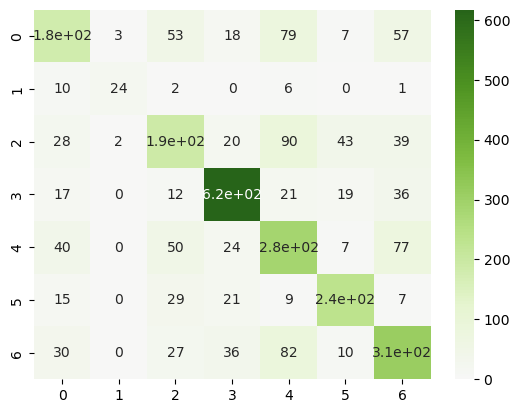

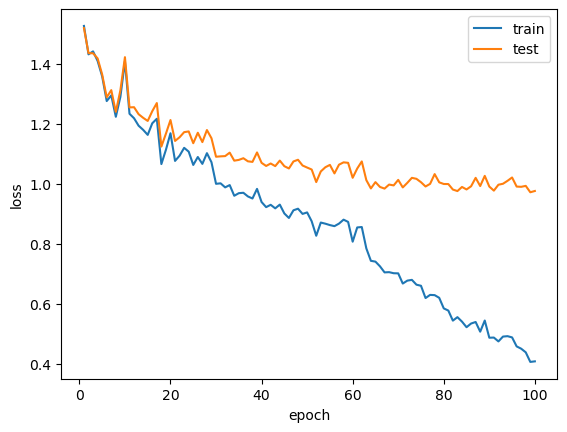

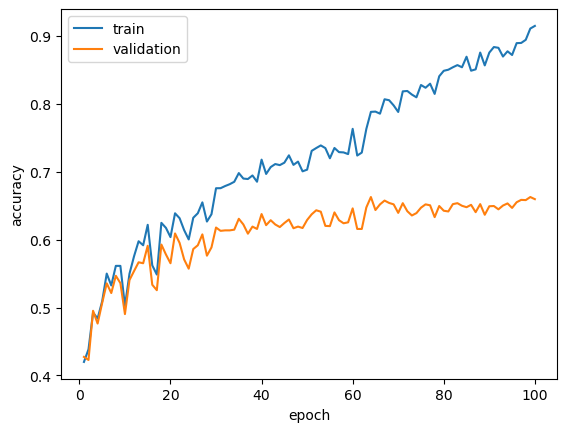

In [274]:
model = run_pipeline(train_not_augmented, val_not_augmented, test_not_augmented, transform,
             epochs=100, batch_size=512, test_step=1, lr=1e-3, weight_decay=0.01)


* Model training * 
* Epoch #1
	Train accuracy 0.4607599431818182
	Test accuracy 0.45942180424939044

	Train loss tensor(1.4506)
	Test loss tensor(1.4503)

* Epoch #2
	Train accuracy 0.4806906960227273
	Test accuracy 0.47579240682688956

	Train loss tensor(1.3243)
	Test loss tensor(1.3361)

* Epoch #3
	Train accuracy 0.4513494318181818
	Test accuracy 0.4378265412748171

	Train loss tensor(1.4356)
	Test loss tensor(1.4318)

* Epoch #4
	Train accuracy 0.5228160511363636
	Test accuracy 0.5214211076280042

	Train loss tensor(1.2611)
	Test loss tensor(1.2768)

* Epoch #5
	Train accuracy 0.56005859375
	Test accuracy 0.5562521769418322

	Train loss tensor(1.1530)
	Test loss tensor(1.1740)

* Epoch #6
	Train accuracy 0.5495827414772727
	Test accuracy 0.5370950888192267

	Train loss tensor(1.2170)
	Test loss tensor(1.2593)

* Epoch #7
	Train accuracy 0.5451438210227273
	Test accuracy 0.5266457680250783

	Train loss tensor(1.1749)
	Test loss tensor(1.2040)

* Epoch #8
	Train accuracy 0.58811257

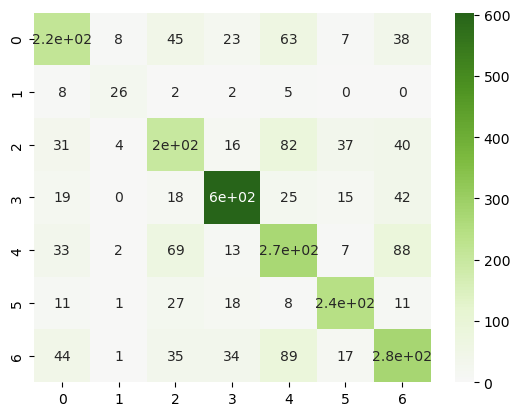

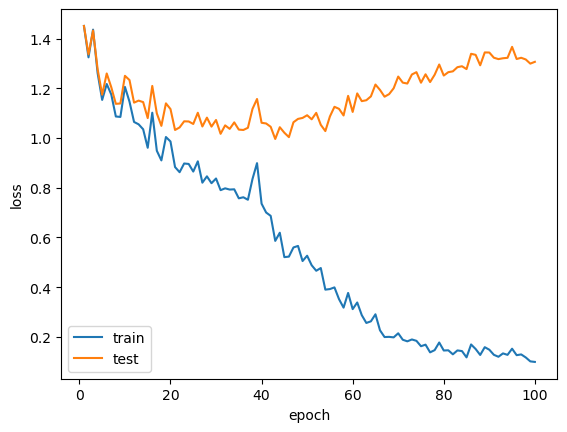

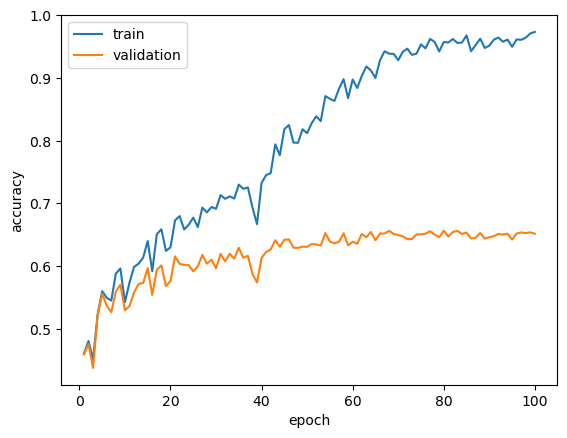

In [272]:
# add dropouts with (0.1)
model = run_pipeline(train_not_augmented, val_not_augmented, test_not_augmented, transform,
             epochs=100, batch_size=512, test_step=1, lr=1e-3, weight_decay=0.01)


* Model training * 
* Epoch #1
	Train accuracy 0.4521484375
	Test accuracy 0.4482758620689655

	Train loss tensor(1.6389)
	Test loss tensor(1.6522)

* Epoch #2
	Train accuracy 0.49409623579545453
	Test accuracy 0.4959944270289098

	Train loss tensor(1.3072)
	Test loss tensor(1.3197)

* Epoch #3
	Train accuracy 0.5173561789772727
	Test accuracy 0.5106234761407176

	Train loss tensor(1.2776)
	Test loss tensor(1.2909)

* Epoch #4
	Train accuracy 0.5486061789772727
	Test accuracy 0.5357018460466736

	Train loss tensor(1.1882)
	Test loss tensor(1.2226)

* Epoch #5
	Train accuracy 0.5718661221590909
	Test accuracy 0.5527690700104493

	Train loss tensor(1.1271)
	Test loss tensor(1.1592)

* Epoch #6
	Train accuracy 0.5675159801136364
	Test accuracy 0.554858934169279

	Train loss tensor(1.2113)
	Test loss tensor(1.2494)

* Epoch #7
	Train accuracy 0.5529119318181818
	Test accuracy 0.5259491466388018

	Train loss tensor(1.1731)
	Test loss tensor(1.2343)

* Epoch #8
	Train accuracy 0.60063032670

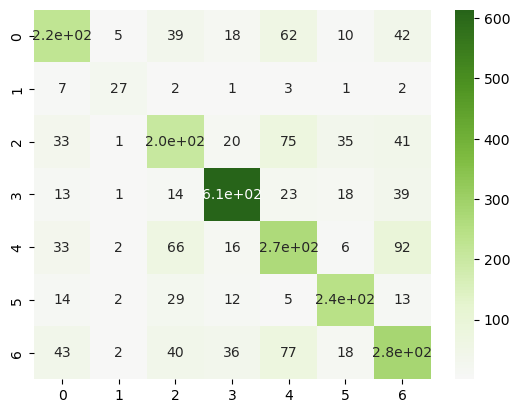

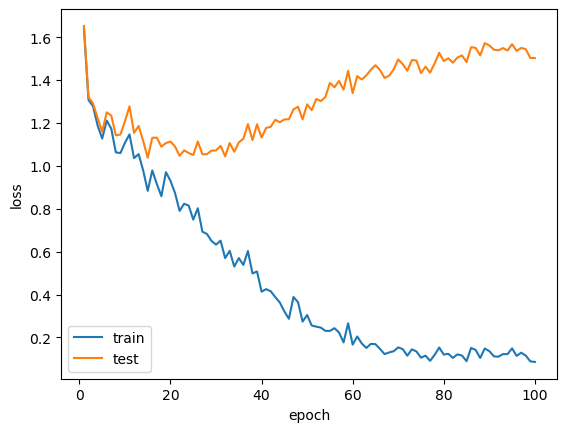

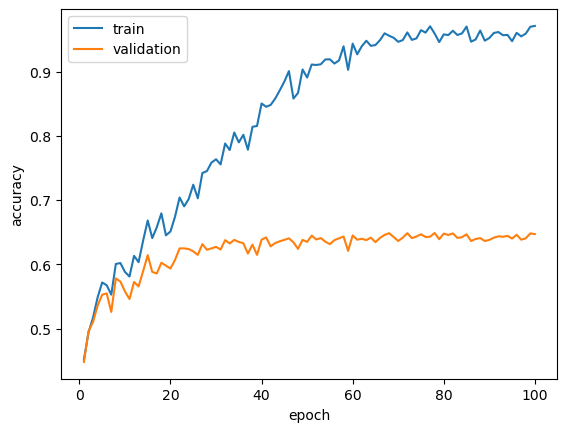

In [270]:
model = run_pipeline(train_not_augmented, val_not_augmented, test_not_augmented, transform,
             epochs=100, batch_size=512, test_step=1, lr=1e-3, weight_decay=0.01)


* Model training * 
* Epoch #1
	Train accuracy 0.4582297585227273
	Test accuracy 0.4548937652385928

	Train loss tensor(1.5779)
	Test loss tensor(1.5824)

* Epoch #2
	Train accuracy 0.4470436789772727
	Test accuracy 0.44757924068268895

	Train loss tensor(1.4501)
	Test loss tensor(1.4655)

* Epoch #3
	Train accuracy 0.5098544034090909
	Test accuracy 0.49669104841518635

	Train loss tensor(1.2821)
	Test loss tensor(1.2980)

* Epoch #4
	Train accuracy 0.5545099431818182
	Test accuracy 0.5370950888192267

	Train loss tensor(1.1855)
	Test loss tensor(1.2349)

* Epoch #5
	Train accuracy 0.5868252840909091
	Test accuracy 0.5733194009056078

	Train loss tensor(1.0865)
	Test loss tensor(1.1266)

* Epoch #6
	Train accuracy 0.5569069602272727
	Test accuracy 0.5478927203065134

	Train loss tensor(1.2741)
	Test loss tensor(1.3181)

* Epoch #7
	Train accuracy 0.5218394886363636
	Test accuracy 0.5106234761407176

	Train loss tensor(1.2606)
	Test loss tensor(1.3197)

* Epoch #8
	Train accuracy 0.607

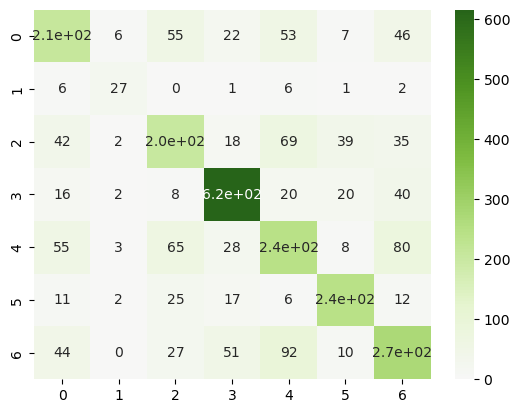

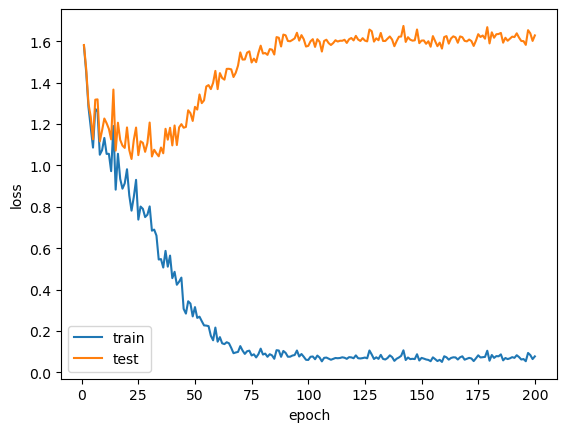

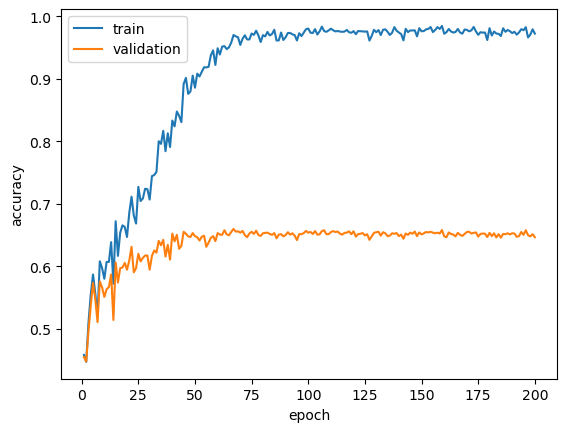

In [269]:
model = run_pipeline(train_not_augmented, val_not_augmented, test_not_augmented, transform,
             epochs=200, batch_size=512, test_step=1, lr=1e-3, weight_decay=0)

## Baseline for ResNet18  <br>
Оn beforehand augmented data as below - 60% <br>
Оn online augmentation as above - 53 %

## Baseline resnet18 with dropout(p=0.5) before FC


* Model training * 
* Epoch #1
	Train accuracy 0.43190187101910826
	Test accuracy 0.44618599791013586

	Train loss tensor(1.7479)
	Test loss tensor(1.5874)

* Epoch #2
	Train accuracy 0.5306093252388535
	Test accuracy 0.5370950888192267

	Train loss tensor(1.3843)
	Test loss tensor(1.3067)

* Epoch #3
	Train accuracy 0.5436094247611465
	Test accuracy 0.5228143504005573

	Train loss tensor(1.3082)
	Test loss tensor(1.3282)

* Epoch #4
	Train accuracy 0.35718550955414013
	Test accuracy 0.4573319400905608

	Train loss tensor(2.6894)
	Test loss tensor(1.5776)

* Epoch #5
	Train accuracy 0.6224932822452229
	Test accuracy 0.5837687216997561

	Train loss tensor(1.1758)
	Test loss tensor(1.1850)

* Epoch #6
	Train accuracy 0.6208387241242038
	Test accuracy 0.5736677115987461

	Train loss tensor(1.1502)
	Test loss tensor(1.1874)

* Epoch #7
	Train accuracy 0.6233143411624203
	Test accuracy 0.5395332636711947

	Train loss tensor(1.1823)
	Test loss tensor(1.3116)

* Epoch #8
	Train accuracy 0.64

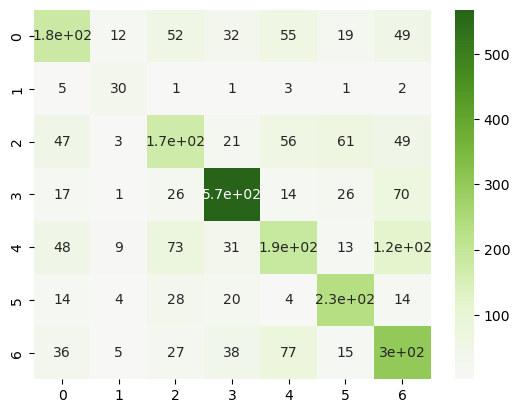

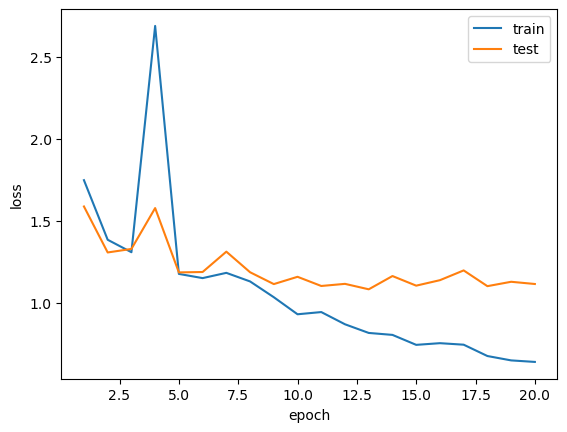

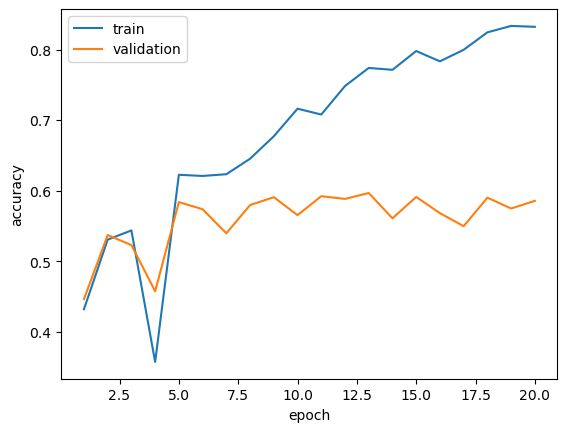

In [86]:
model = run_pipeline(train_augmented, val_augmented, test_augmented,
                     epochs=20, batch_size=256, test_step=1, lr=1e-3, weight_decay=0.1)

## Baseline resnet18 with FC


* Model training * 
* Epoch #1
	Train accuracy 0.38817426353503187
	Test accuracy 0.42459073493556254

	Train loss tensor(1.7784)
	Test loss tensor(1.7288)

* Epoch #2
	Train accuracy 0.4370956906847134
	Test accuracy 0.4486241727621038

	Train loss tensor(1.7095)
	Test loss tensor(1.6562)

* Epoch #3
	Train accuracy 0.48872910031847133
	Test accuracy 0.48032044583768724

	Train loss tensor(1.6389)
	Test loss tensor(1.6165)

* Epoch #4
	Train accuracy 0.5373581807324841
	Test accuracy 0.5294322535701846

	Train loss tensor(1.5923)
	Test loss tensor(1.5471)

* Epoch #5
	Train accuracy 0.5455625497611465
	Test accuracy 0.5496342737722049

	Train loss tensor(1.5664)
	Test loss tensor(1.5449)

* Epoch #6
	Train accuracy 0.5696096238057324
	Test accuracy 0.5520724486241727

	Train loss tensor(1.4846)
	Test loss tensor(1.4840)

* Epoch #7
	Train accuracy 0.5711397790605095
	Test accuracy 0.5464994775339603

	Train loss tensor(1.5052)
	Test loss tensor(1.4742)

* Epoch #8
	Train accuracy 0.5

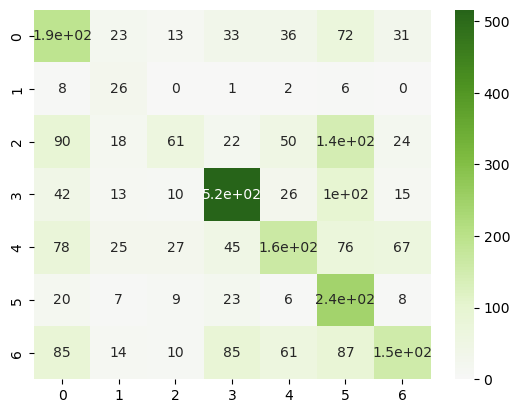

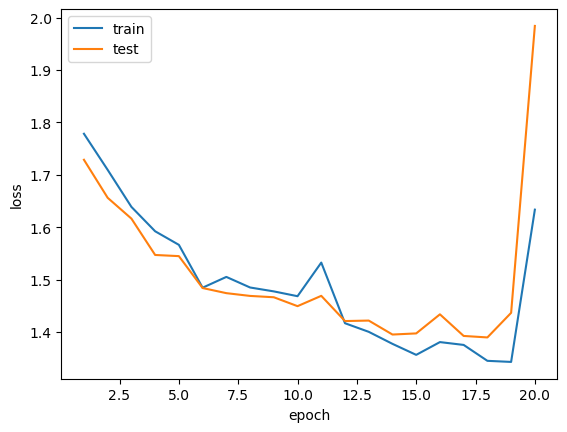

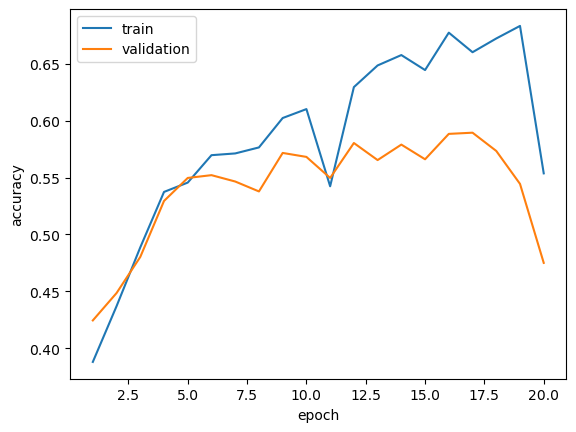

In [90]:
model = run_pipeline(train_augmented, val_augmented, test_augmented,
                     epochs=20, batch_size=256, test_step=1, lr=1e-3, weight_decay=0.1)

# Some thoughts about project improvements.


* Imrove data: <br>
&nbsp; Think of getting newer dataset for image classification with higher resolution and better quality images <br>

* Imrove augmentation: <br>
&nbsp; In these pipelines i agumented data by batches which speeds up training but gives some regularization affect that could be a problem for high accuracy. <br>
&nbsp; That's why it'd be a good idea to augment on-the-fly individually or pre-augment all the data, but there's it's own disadvatages

* Imrove training: <br>
&nbsp; We can use some techniques such as super-convergence for instance <br>
&nbsp; We can use some other LR-shedulers <br>
&nbsp; We can make use of two T4 GPU's on kaggle.com <br>
&nbsp; Try different sampling techniques other than existing RandomSampler due to the class imbalance <br>

* Imrove model: <br>
&nbsp; Adding additional layers and experimenting with existing one's, given the previous improvements, will be easier <br>
&nbsp; Try transfer learning based on broader range of pre-trained models  <br>

# Conlusions

In current work i trained model on the base of ResNet18 which maximum test accuracy of around 68%.

During this project, i have got better understanding of PyTorch and its nuances. I learned and experemented with different data loading & preprocessing techniques (e.g. Nvidia DALI). In the process of completing study, I get acquainted with Kaggle and Google Colaboratory better. Deepen my understanding of terminology, built models, trained them and evaluated on test data, suggested base improvements & thoughts.